##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
# !pip install keras_tuner

In [3]:
# !pip install tensorflow

In [4]:
import PIL
import tensorflow as tf
import os, pathlib
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)


## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [6]:
#walk through the directory and list the numbers of files
for dirpath, dirnames, filenames in os.walk("Flowers/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 8 directories and 1 images in Flowers/
There are 0 directories and 929 images in Flowers/Babi
There are 0 directories and 360 images in Flowers/Pingpong
There are 0 directories and 696 images in Flowers/Chrysanthemum
There are 0 directories and 171 images in Flowers/Rosy
There are 0 directories and 623 images in Flowers/Tana
There are 0 directories and 518 images in Flowers/Hydrangeas
There are 0 directories and 969 images in Flowers/Lisianthus
There are 0 directories and 353 images in Flowers/Calimerio


In [7]:
num_of_flower_groups = len(os.listdir("Flowers/"))
print("The number of groups: ", num_of_flower_groups )

The number of groups:  9


In [8]:
data_dir = pathlib.Path("Flowers/")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # creating a list of class names from subdirectory 
print(class_names)


['.DS_Store' 'Babi' 'Calimerio' 'Chrysanthemum' 'Hydrangeas' 'Lisianthus'
 'Pingpong' 'Rosy' 'Tana']


In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4619


Here are some Babi Flowers:

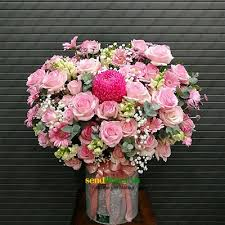

In [10]:
Babi = list(data_dir.glob('Babi/*'))
PIL.Image.open(str(Babi[0]))

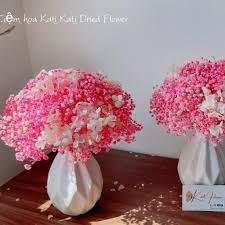

In [11]:
PIL.Image.open(str(Babi[1]))

And some Tana:

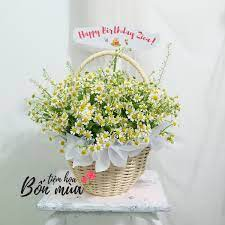

In [12]:
Tana = list(data_dir.glob('Tana/*'))
PIL.Image.open(str(Tana[0]))

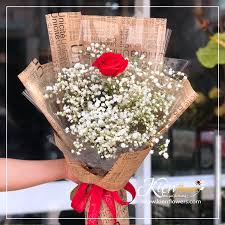

In [13]:
PIL.Image.open(str(Tana[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4619 files belonging to 8 classes.
Using 3696 files for training.
Metal device set to: Apple M1 Pro


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4619 files belonging to 8 classes.
Using 923 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [17]:
class_names = train_ds.class_names
print(class_names)

['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']


In [50]:
# Define the directory containing your image data
data_dir = "Flowers/"

# Define the list of subdirectories (classes) in your data directory
subdirs = ['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']

# Define the input size for your model
input_size = (224, 224)

# Load the images and labels into lists
X = []
y = []
for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(data_dir, subdir)
    for file in os.listdir(subdir_path):
        img_path = os.path.join(subdir_path, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, input_size)
        X.append(img)
        y.append(i)

# Convert the data and labels lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shape of the arrays to verify that they are compatible with your model
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (4619, 224, 224, 3)
y shape: (4619,)


## Spliting data

In [51]:
# Flatten the image arrays to a single-dimensional array
X = np.reshape(X, (X.shape[0], -1))

# Print the shape of the flattened array to verify that it is a single-dimensional array
print("Flattened X shape:", X.shape)

# Split the data into train and test sets using train_test_split()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Flattened X shape: (4619, 150528)


In [52]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 8)
y_test = to_categorical(y_test, 8)

## Visualize the data

Here are the first nine images from the training dataset:

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

2023-04-27 20:19:04.652988: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [24]:
normalization_layer = layers.Rescaling(1./127.5, offset=-1)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

-1.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [29]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
116/116 [==============================] - 4s 33ms/step - loss: 1.9362 - accuracy: 0.2803 - val_loss: 1.7058 - val_accuracy: 0.4182
Epoch 2/10
116/116 [==============================] - 3s 30ms/step - loss: 1.5545 - accuracy: 0.4494 - val_loss: 1.5321 - val_accuracy: 0.4778
Epoch 3/10
116/116 [==============================] - 3s 30ms/step - loss: 1.2811 - accuracy: 0.5460 - val_loss: 1.4832 - val_accuracy: 0.4843
Epoch 4/10
116/116 [==============================] - 3s 30ms/step - loss: 1.0644 - accuracy: 0.6201 - val_loss: 1.3572 - val_accuracy: 0.5168
Epoch 5/10
116/116 [==============================] - 3s 29ms/step - loss: 0.8060 - accuracy: 0.7194 - val_loss: 1.5203 - val_accuracy: 0.5222
Epoch 6/10
116/116 [==============================] - 3s 29ms/step - loss: 0.5542 - accuracy: 0.8141 - val_loss: 1.6459 - val_accuracy: 0.5135
Epoch 7/10
116/116 [==============================] - 3s 29ms/step - loss: 0.3754 - accuracy: 0.8823 - val_loss: 1.9715 - val_accuracy: 0.5049

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

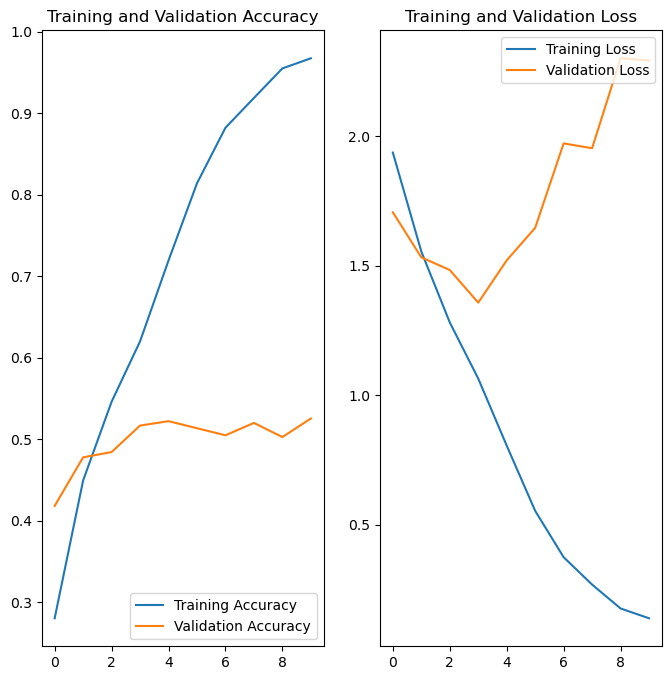

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [31]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.5),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

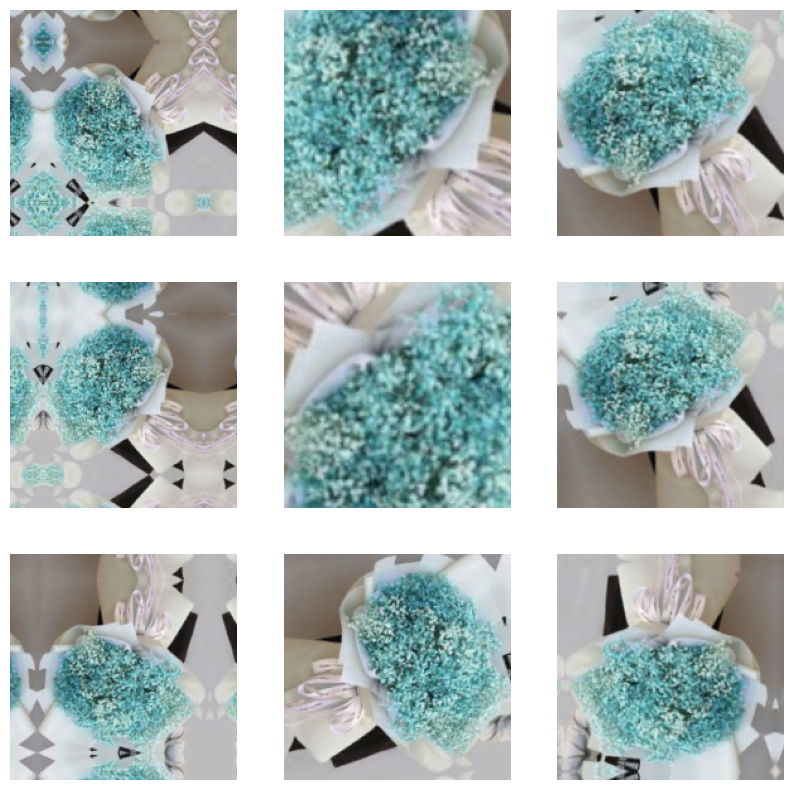

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [33]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [36]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
116/116 [==============================] - 7s 52ms/step - loss: 1.9906 - accuracy: 0.2205 - val_loss: 1.9221 - val_accuracy: 0.2405
Epoch 2/15
116/116 [==============================] - 6s 49ms/step - loss: 1.7728 - accuracy: 0.3485 - val_loss: 1.5813 - val_accuracy: 0.4431
Epoch 3/15
116/116 [==============================] - 6s 51ms/step - loss: 1.5962 - accuracy: 0.4110 - val_loss: 1.6029 - val_accuracy: 0.4334
Epoch 4/15
116/116 [==============================] - 6s 51ms/step - loss: 1.5030 - accuracy: 0.4505 - val_loss: 1.4252 - val_accuracy: 0.5038
Epoch 5/15
116/116 [==============================] - 6s 52ms/step - loss: 1.4471 - accuracy: 0.4784 - val_loss: 1.4319 - val_accuracy: 0.4940
Epoch 6/15
116/116 [==============================] - 6s 51ms/step - loss: 1.4137 - accuracy: 0.4816 - val_loss: 1.3945 - val_accuracy: 0.5125
Epoch 7/15
116/116 [==============================] - 6s 52ms/step - loss: 1.3469 - accuracy: 0.5200 - val_loss: 1.5316 - val_accuracy: 0.4691

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

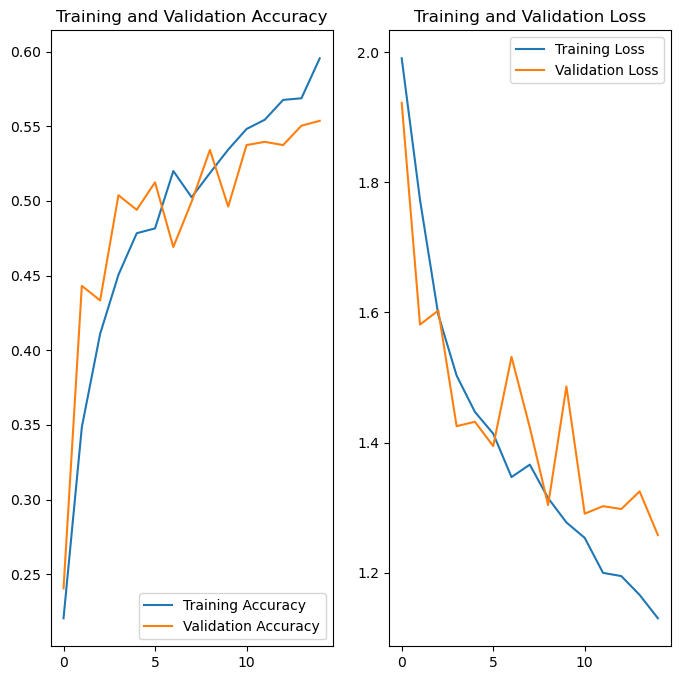

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Hyperparameter Tuning

In [60]:
import optuna
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import os

# Load the data
train_data_dir = 'Flowers/'
img_width, img_height = 64, 64
batch_size = 32

# Define the data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True)

# # Define data augmentation parameters
# train_datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2)

# Read the training data from the directory
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

# Split the data into training and validation sets
X_train, X_test, y_train, y_test =  train_test_split(train_generator[0][0], train_generator[0][1], test_size=0.2, random_state=42)


# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

# Define objective function to minimize with Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_filters = trial.suggest_int('n_filters', 32, 128, log=True)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_int('batch_size', 16, 64, log=True)

    # Build CNN model
    model = Sequential([
        Conv2D(n_filters, kernel_size, activation=activation, input_shape=X_train[0].shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),
        Conv2D(n_filters, kernel_size, activation=activation),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation=activation),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Compile model with specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Fit model on training data with data augmentation
    model.fit(datagen.flow(X_train, y_train, batch_size=batch_size, subset='training'),
              validation_data=datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation'),
              epochs=10)

    # Evaluate model on testing data
    score = model.evaluate(X_test, y_test)

    # Return negative accuracy (to minimize) for Optuna optimization
    return score[1]

# Run Optuna optimization to find best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print best hyperparameters and corresponding accuracy
print('Best hyperparameters: {}'.format(study.best_params))
print('Best accuracy: {}'.format(study.best_value))

Found 4619 images belonging to 8 classes.


[I 2023-04-27 20:41:57,285] A new study created in memory with name: no-name-17458c9e-01a7-414d-b07d-0ed914b964eb


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6397 - accuracy: 0.6875 - val_loss: 1.7454 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 233ms/step - loss: 1.7473 - accuracy: 0.8750 - val_loss: 1.6940 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 102ms/step - loss: 1.6995 - accuracy: 0.8750 - val_loss: 1.4147 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 107ms/step - loss: 1.5464 - accuracy: 0.8750 - val_loss: 11.4823 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 110ms/step - loss: 11.4888 - accuracy: 0.1250 - val_loss: 11.1335 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 221ms/step - loss: 11.1324 - accuracy: 0.1250 - val_loss: 10.7391 - val_accuracy: 0.1250
Epoch 7/10
1/1 [==============================] - 0s 154ms/step - loss: 10.4600 - accuracy: 0.1250 - val_loss: 1.0790 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=

[I 2023-04-27 20:42:00,483] Trial 0 finished with value: 0.875 and parameters: {'n_filters': 43, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.20769323446590243, 'batch_size': 34}. Best is trial 0 with value: 0.875.


Epoch 1/10
2/2 [==============================] - 2s 967ms/step - loss: 0.7433 - accuracy: 0.7625 - val_loss: 1.6714 - val_accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 0s 217ms/step - loss: 1.3518 - accuracy: 0.8750 - val_loss: 11.5769 - val_accuracy: 0.1250
Epoch 3/10
2/2 [==============================] - 0s 312ms/step - loss: 11.7407 - accuracy: 0.1250 - val_loss: 10.9749 - val_accuracy: 0.1250
Epoch 4/10
2/2 [==============================] - 0s 127ms/step - loss: 10.3912 - accuracy: 0.1250 - val_loss: 9.3328 - val_accuracy: 0.1250
Epoch 5/10
2/2 [==============================] - 0s 50ms/step - loss: 8.3767 - accuracy: 0.1250 - val_loss: 5.2319 - val_accuracy: 0.1250
Epoch 6/10
2/2 [==============================] - 0s 81ms/step - loss: 4.2346 - accuracy: 0.2375 - val_loss: 0.3825 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 0s 143ms/step - loss: 0.4011 - accuracy: 0.8750 - val_loss: 0.3900 - val_accuracy: 0.8750
Epoch 8/10
2/2 [==

[I 2023-04-27 20:42:04,904] Trial 1 finished with value: 0.875 and parameters: {'n_filters': 45, 'kernel_size': 3, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.28076190252205924, 'batch_size': 17}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6340 - accuracy: 0.8375 - val_loss: 1.5484 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 246ms/step - loss: 1.5384 - accuracy: 0.8750 - val_loss: 10.8121 - val_accuracy: 0.1250
Epoch 3/10
1/1 [==============================] - 0s 221ms/step - loss: 10.8012 - accuracy: 0.1250 - val_loss: 0.5001 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 128ms/step - loss: 0.4853 - accuracy: 0.8750 - val_loss: 4.2661 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 227ms/step - loss: 4.2754 - accuracy: 0.1250 - val_loss: 2.7303 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 131ms/step - loss: 2.7515 - accuracy: 0.1250 - val_loss: 1.5093 - val_accuracy: 0.1250
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 1.5259 - accuracy: 0.1250 - val_loss: 0.9789 - val_accuracy: 0.1250
Epoch 8/10
1/1 [======

[I 2023-04-27 20:42:08,183] Trial 2 finished with value: 0.875 and parameters: {'n_filters': 38, 'kernel_size': 5, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.014647769450089387, 'batch_size': 50}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7191 - accuracy: 0.2000 - val_loss: 1.5369 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 261ms/step - loss: 1.5351 - accuracy: 0.8750 - val_loss: 1.3909 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 195ms/step - loss: 1.3710 - accuracy: 0.8750 - val_loss: 10.2333 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 175ms/step - loss: 10.2219 - accuracy: 0.1250 - val_loss: 9.8829 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 202ms/step - loss: 9.8719 - accuracy: 0.1250 - val_loss: 9.6263 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 84ms/step - loss: 9.6155 - accuracy: 0.1250 - val_loss: 9.4107 - val_accuracy: 0.1250
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 9.4001 - accuracy: 0.1250 - val_loss: 9.2189 - val_accuracy: 0.1250
Epoch 8/10
1/1 [=======

[I 2023-04-27 20:42:11,727] Trial 3 finished with value: 0.125 and parameters: {'n_filters': 100, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.0024888855696452716, 'batch_size': 38}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7080 - accuracy: 0.4250 - val_loss: 0.5973 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 190ms/step - loss: 0.8327 - accuracy: 0.8750 - val_loss: 0.3822 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 156ms/step - loss: 0.4338 - accuracy: 0.8750 - val_loss: 0.4765 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 135ms/step - loss: 0.4323 - accuracy: 0.8750 - val_loss: 0.5037 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 140ms/step - loss: 0.4529 - accuracy: 0.8750 - val_loss: 0.4619 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 230ms/step - loss: 0.4137 - accuracy: 0.8750 - val_loss: 0.3999 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 161ms/step - loss: 0.3860 - accuracy: 0.8750 - val_loss: 0.3807 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=======

[I 2023-04-27 20:42:14,636] Trial 4 finished with value: 0.875 and parameters: {'n_filters': 94, 'kernel_size': 4, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.15742298664662108, 'batch_size': 51}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.9214 - accuracy: 0.2750 - val_loss: 0.7559 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 283ms/step - loss: 0.7906 - accuracy: 0.8750 - val_loss: 0.7438 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 263ms/step - loss: 0.7779 - accuracy: 0.8750 - val_loss: 0.7329 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.7665 - accuracy: 0.8750 - val_loss: 0.7228 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 213ms/step - loss: 0.7559 - accuracy: 0.8750 - val_loss: 0.7133 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 136ms/step - loss: 0.7460 - accuracy: 0.8750 - val_loss: 0.7041 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 105ms/step - loss: 0.7364 - accuracy: 0.8750 - val_loss: 0.6953 - val_accuracy: 0.8750
Epoch 8/10
1/1 [========

[I 2023-04-27 20:42:19,832] Trial 5 finished with value: 0.875 and parameters: {'n_filters': 49, 'kernel_size': 5, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.4180208985707798, 'batch_size': 21}. Best is trial 0 with value: 0.875.


Epoch 1/10
2/2 [==============================] - 2s 742ms/step - loss: 0.4658 - accuracy: 0.7625 - val_loss: 0.3809 - val_accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 0s 170ms/step - loss: 0.4022 - accuracy: 0.8750 - val_loss: 0.4427 - val_accuracy: 0.8750
Epoch 3/10
2/2 [==============================] - 0s 135ms/step - loss: 0.3923 - accuracy: 0.8750 - val_loss: 0.3876 - val_accuracy: 0.8750
Epoch 4/10
2/2 [==============================] - 0s 78ms/step - loss: 0.3899 - accuracy: 0.8750 - val_loss: 0.3854 - val_accuracy: 0.8750
Epoch 5/10
2/2 [==============================] - 0s 161ms/step - loss: 0.3917 - accuracy: 0.8750 - val_loss: 0.4236 - val_accuracy: 0.8750
Epoch 6/10
2/2 [==============================] - 0s 74ms/step - loss: 0.3904 - accuracy: 0.8750 - val_loss: 0.4302 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 0s 75ms/step - loss: 0.3858 - accuracy: 0.8750 - val_loss: 0.4057 - val_accuracy: 0.8750
Epoch 8/10
2/2 [=======

[I 2023-04-27 20:42:23,242] Trial 6 finished with value: 0.875 and parameters: {'n_filters': 45, 'kernel_size': 3, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.1338951792308432, 'batch_size': 16}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.9676 - accuracy: 0.1625 - val_loss: 1.4549 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 202ms/step - loss: 1.6515 - accuracy: 0.8750 - val_loss: 5.6726 - val_accuracy: 0.1250
Epoch 3/10
1/1 [==============================] - 0s 136ms/step - loss: 1.3153 - accuracy: 0.8750 - val_loss: 10.9212 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 100ms/step - loss: 11.1096 - accuracy: 0.1250 - val_loss: 10.5714 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 10.7554 - accuracy: 0.1250 - val_loss: 10.3149 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 164ms/step - loss: 10.4958 - accuracy: 0.1250 - val_loss: 10.0994 - val_accuracy: 0.1250
Epoch 7/10
1/1 [==============================] - 0s 219ms/step - loss: 10.2776 - accuracy: 0.1250 - val_loss: 9.9078 - val_accuracy: 0.1250
Epoch 8/10
1/1 [

[I 2023-04-27 20:42:26,354] Trial 7 finished with value: 0.125 and parameters: {'n_filters': 74, 'kernel_size': 3, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.31892358057460823, 'batch_size': 22}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5972 - accuracy: 0.7625 - val_loss: 0.9195 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 225ms/step - loss: 0.9108 - accuracy: 0.8750 - val_loss: 0.9022 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 209ms/step - loss: 0.8935 - accuracy: 0.8750 - val_loss: 0.8875 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 96ms/step - loss: 0.8788 - accuracy: 0.8750 - val_loss: 0.8742 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.8655 - accuracy: 0.8750 - val_loss: 0.8618 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 236ms/step - loss: 0.8532 - accuracy: 0.8750 - val_loss: 0.8502 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 95ms/step - loss: 0.8416 - accuracy: 0.8750 - val_loss: 0.8392 - val_accuracy: 0.8750
Epoch 8/10
1/1 [==========

[I 2023-04-27 20:42:29,573] Trial 8 finished with value: 0.875 and parameters: {'n_filters': 54, 'kernel_size': 4, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.09886744816205273, 'batch_size': 54}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6880 - accuracy: 0.5375 - val_loss: 0.5286 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 177ms/step - loss: 0.7082 - accuracy: 0.8750 - val_loss: 0.4117 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 93ms/step - loss: 0.4996 - accuracy: 0.8750 - val_loss: 0.4026 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3857 - accuracy: 0.8750 - val_loss: 0.4806 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 104ms/step - loss: 0.4281 - accuracy: 0.8750 - val_loss: 0.5018 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 126ms/step - loss: 0.4449 - accuracy: 0.8750 - val_loss: 0.4762 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 104ms/step - loss: 0.4202 - accuracy: 0.8750 - val_loss: 0.4219 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=========

[I 2023-04-27 20:42:32,011] Trial 9 finished with value: 0.875 and parameters: {'n_filters': 40, 'kernel_size': 5, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.12125501905262503, 'batch_size': 54}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.8750 - accuracy: 0.3500 - val_loss: 0.8492 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 114ms/step - loss: 1.4376 - accuracy: 0.8750 - val_loss: 3.5236 - val_accuracy: 0.1250
Epoch 3/10
1/1 [==============================] - 0s 162ms/step - loss: 0.8266 - accuracy: 0.8750 - val_loss: 11.8251 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 151ms/step - loss: 10.2497 - accuracy: 0.1250 - val_loss: 9.8327 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 112ms/step - loss: 2.8590 - accuracy: 0.1250 - val_loss: 0.5422 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 139ms/step - loss: 1.2417 - accuracy: 0.8750 - val_loss: 1.2823 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 1.5637 - accuracy: 0.8750 - val_loss: 1.4770 - val_accuracy: 0.8750
Epoch 8/10
1/1 [======

[I 2023-04-27 20:42:34,717] Trial 10 finished with value: 0.875 and parameters: {'n_filters': 62, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.4821988899098044, 'batch_size': 32}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6234 - accuracy: 0.7625 - val_loss: 1.8347 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 227ms/step - loss: 1.8501 - accuracy: 0.8750 - val_loss: 1.7916 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 134ms/step - loss: 1.8075 - accuracy: 0.8750 - val_loss: 1.7562 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 155ms/step - loss: 1.7742 - accuracy: 0.8750 - val_loss: 1.7208 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 153ms/step - loss: 1.7431 - accuracy: 0.8750 - val_loss: 1.6642 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 159ms/step - loss: 1.7097 - accuracy: 0.8750 - val_loss: 1.1686 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 66ms/step - loss: 1.5495 - accuracy: 0.8750 - val_loss: 11.4222 - val_accuracy: 0.1250
Epoch 8/10
1/1 [=======

[I 2023-04-27 20:42:37,847] Trial 11 finished with value: 0.875 and parameters: {'n_filters': 34, 'kernel_size': 3, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.2604575594232904, 'batch_size': 28}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6670 - accuracy: 0.6500 - val_loss: 1.7624 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 227ms/step - loss: 1.7879 - accuracy: 0.8750 - val_loss: 1.0094 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 244ms/step - loss: 1.3293 - accuracy: 0.8750 - val_loss: 12.1138 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 305ms/step - loss: 12.0715 - accuracy: 0.1250 - val_loss: 6.8194 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 158ms/step - loss: 5.5540 - accuracy: 0.1250 - val_loss: 1.5222 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 84ms/step - loss: 1.5307 - accuracy: 0.8750 - val_loss: 1.2044 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 1.2069 - accuracy: 0.8750 - val_loss: 0.9448 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=======

[I 2023-04-27 20:42:41,232] Trial 12 finished with value: 0.875 and parameters: {'n_filters': 33, 'kernel_size': 3, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.24539155995946194, 'batch_size': 37}. Best is trial 0 with value: 0.875.


Epoch 1/10
2/2 [==============================] - 2s 849ms/step - loss: 1.6130 - accuracy: 0.8000 - val_loss: 1.6735 - val_accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 0s 103ms/step - loss: 1.6808 - accuracy: 0.8750 - val_loss: 3.3263 - val_accuracy: 0.1250
Epoch 3/10
2/2 [==============================] - 0s 89ms/step - loss: 9.6834 - accuracy: 0.2750 - val_loss: 10.7797 - val_accuracy: 0.1250
Epoch 4/10
2/2 [==============================] - 0s 121ms/step - loss: 2.3367 - accuracy: 0.6875 - val_loss: 0.5130 - val_accuracy: 0.8750
Epoch 5/10
2/2 [==============================] - 0s 185ms/step - loss: 0.5282 - accuracy: 0.8750 - val_loss: 0.4381 - val_accuracy: 0.8750
Epoch 6/10
2/2 [==============================] - 0s 75ms/step - loss: 0.4024 - accuracy: 0.8750 - val_loss: 0.3974 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 0s 47ms/step - loss: 0.3970 - accuracy: 0.8750 - val_loss: 0.4191 - val_accuracy: 0.8750
Epoch 8/10
2/2 [======

[I 2023-04-27 20:42:45,363] Trial 13 finished with value: 0.875 and parameters: {'n_filters': 45, 'kernel_size': 3, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.3140174125270951, 'batch_size': 16}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 1.0422 - accuracy: 0.1625 - val_loss: 0.8161 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 127ms/step - loss: 0.8064 - accuracy: 0.8750 - val_loss: 0.8057 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 192ms/step - loss: 0.7961 - accuracy: 0.8750 - val_loss: 0.7961 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 129ms/step - loss: 0.7867 - accuracy: 0.8750 - val_loss: 0.7871 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 174ms/step - loss: 0.7778 - accuracy: 0.8750 - val_loss: 0.7784 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.7694 - accuracy: 0.8750 - val_loss: 0.7701 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 147ms/step - loss: 0.7612 - accuracy: 0.8750 - val_loss: 0.7620 - val_accuracy: 0.8750
Epoch 8/10
1/1 [========

[I 2023-04-27 20:42:48,112] Trial 14 finished with value: 0.875 and parameters: {'n_filters': 54, 'kernel_size': 4, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.20637803955372536, 'batch_size': 25}. Best is trial 0 with value: 0.875.


Epoch 1/10
2/2 [==============================] - 3s 1s/step - loss: 0.8415 - accuracy: 0.3500 - val_loss: 1.4402 - val_accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 0s 221ms/step - loss: 1.5012 - accuracy: 0.8750 - val_loss: 10.6907 - val_accuracy: 0.1250
Epoch 3/10
2/2 [==============================] - 0s 79ms/step - loss: 8.4331 - accuracy: 0.1625 - val_loss: 1.3932 - val_accuracy: 0.8750
Epoch 4/10
2/2 [==============================] - 0s 139ms/step - loss: 1.4161 - accuracy: 0.8750 - val_loss: 1.3462 - val_accuracy: 0.8750
Epoch 5/10
2/2 [==============================] - 0s 50ms/step - loss: 1.3868 - accuracy: 0.8750 - val_loss: 1.2862 - val_accuracy: 0.8750
Epoch 6/10
2/2 [==============================] - 0s 118ms/step - loss: 1.3055 - accuracy: 0.8750 - val_loss: 1.2057 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 0s 124ms/step - loss: 1.2070 - accuracy: 0.8750 - val_loss: 1.1348 - val_accuracy: 0.8750
Epoch 8/10
2/2 [========

[I 2023-04-27 20:42:52,803] Trial 15 finished with value: 0.875 and parameters: {'n_filters': 39, 'kernel_size': 3, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.33891584438170674, 'batch_size': 19}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6578 - accuracy: 0.5750 - val_loss: 1.8580 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 231ms/step - loss: 1.8597 - accuracy: 0.8750 - val_loss: 1.8111 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 105ms/step - loss: 1.8126 - accuracy: 0.8750 - val_loss: 1.7757 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 127ms/step - loss: 1.7771 - accuracy: 0.8750 - val_loss: 1.7457 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 211ms/step - loss: 1.7470 - accuracy: 0.8750 - val_loss: 1.7188 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 125ms/step - loss: 1.7201 - accuracy: 0.8750 - val_loss: 1.6940 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 226ms/step - loss: 1.6953 - accuracy: 0.8750 - val_loss: 1.6706 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=======

[I 2023-04-27 20:42:56,019] Trial 16 finished with value: 0.875 and parameters: {'n_filters': 126, 'kernel_size': 5, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.22623844215100278, 'batch_size': 28}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7056 - accuracy: 0.4625 - val_loss: 1.6872 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 234ms/step - loss: 1.7061 - accuracy: 0.8750 - val_loss: 1.6352 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 235ms/step - loss: 1.6599 - accuracy: 0.8750 - val_loss: 1.2976 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 1.4480 - accuracy: 0.8750 - val_loss: 11.1549 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 11.2400 - accuracy: 0.1250 - val_loss: 8.5403 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 127ms/step - loss: 7.8882 - accuracy: 0.1250 - val_loss: 1.1614 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 60ms/step - loss: 1.2201 - accuracy: 0.8750 - val_loss: 0.9115 - val_accuracy: 0.8750
Epoch 8/10
1/1 [========

[I 2023-04-27 20:42:59,189] Trial 17 finished with value: 0.875 and parameters: {'n_filters': 32, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.18564868146293248, 'batch_size': 42}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.8381 - accuracy: 0.2000 - val_loss: 0.4275 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 139ms/step - loss: 0.7163 - accuracy: 0.8750 - val_loss: 0.3800 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 128ms/step - loss: 0.5080 - accuracy: 0.8750 - val_loss: 0.4573 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 174ms/step - loss: 0.3882 - accuracy: 0.8750 - val_loss: 0.5354 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 136ms/step - loss: 0.4423 - accuracy: 0.8750 - val_loss: 0.5372 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 126ms/step - loss: 0.4467 - accuracy: 0.8750 - val_loss: 0.4895 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 87ms/step - loss: 0.4102 - accuracy: 0.8750 - val_loss: 0.4277 - val_accuracy: 0.8750
Epoch 8/10
1/1 [========

[I 2023-04-27 20:43:02,017] Trial 18 finished with value: 0.875 and parameters: {'n_filters': 62, 'kernel_size': 4, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.2630850476406375, 'batch_size': 62}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7579 - accuracy: 0.5750 - val_loss: 0.8683 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 282ms/step - loss: 0.8919 - accuracy: 0.8750 - val_loss: 0.8529 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 225ms/step - loss: 0.8761 - accuracy: 0.8750 - val_loss: 0.8396 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 269ms/step - loss: 0.8625 - accuracy: 0.8750 - val_loss: 0.8275 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 104ms/step - loss: 0.8501 - accuracy: 0.8750 - val_loss: 0.8162 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 109ms/step - loss: 0.8386 - accuracy: 0.8750 - val_loss: 0.8054 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 122ms/step - loss: 0.8277 - accuracy: 0.8750 - val_loss: 0.7951 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=======

[I 2023-04-27 20:43:05,912] Trial 19 finished with value: 0.875 and parameters: {'n_filters': 44, 'kernel_size': 3, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.38354270597184015, 'batch_size': 33}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5672 - accuracy: 0.7625 - val_loss: 1.6795 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 228ms/step - loss: 1.7106 - accuracy: 0.8750 - val_loss: 1.3567 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 292ms/step - loss: 1.6135 - accuracy: 0.8750 - val_loss: 11.3470 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 145ms/step - loss: 11.3712 - accuracy: 0.1250 - val_loss: 0.4462 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 148ms/step - loss: 0.8015 - accuracy: 0.8750 - val_loss: 8.1544 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 7.2969 - accuracy: 0.1250 - val_loss: 1.3614 - val_accuracy: 0.1250
Epoch 7/10
1/1 [==============================] - 0s 124ms/step - loss: 1.0343 - accuracy: 0.3125 - val_loss: 0.3792 - val_accuracy: 0.8750
Epoch 8/10
1/1 [======

[I 2023-04-27 20:43:09,423] Trial 20 finished with value: 0.875 and parameters: {'n_filters': 54, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.28806437008445085, 'batch_size': 25}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.8206 - accuracy: 0.1625 - val_loss: 0.5320 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 220ms/step - loss: 0.5197 - accuracy: 0.8750 - val_loss: 11.8260 - val_accuracy: 0.1250
Epoch 3/10
1/1 [==============================] - 0s 121ms/step - loss: 11.7831 - accuracy: 0.1250 - val_loss: 11.4684 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 187ms/step - loss: 11.4251 - accuracy: 0.1250 - val_loss: 11.2104 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 117ms/step - loss: 11.1660 - accuracy: 0.1250 - val_loss: 10.9941 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 188ms/step - loss: 10.9489 - accuracy: 0.1250 - val_loss: 10.8020 - val_accuracy: 0.1250
Epoch 7/10
1/1 [==============================] - 0s 221ms/step - loss: 10.7560 - accuracy: 0.1250 - val_loss: 10.6258 - val_accuracy: 0.1250
Epoch 8/10
1

[I 2023-04-27 20:43:13,084] Trial 21 finished with value: 0.125 and parameters: {'n_filters': 37, 'kernel_size': 5, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.06470538944343757, 'batch_size': 42}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6468 - accuracy: 0.6500 - val_loss: 1.7635 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 317ms/step - loss: 1.7565 - accuracy: 0.8750 - val_loss: 1.6492 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 219ms/step - loss: 1.6763 - accuracy: 0.8750 - val_loss: 10.2780 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 129ms/step - loss: 8.6619 - accuracy: 0.1250 - val_loss: 1.5176 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 175ms/step - loss: 1.5392 - accuracy: 0.8750 - val_loss: 1.3326 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 169ms/step - loss: 1.3435 - accuracy: 0.8750 - val_loss: 1.2607 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 92ms/step - loss: 1.2628 - accuracy: 0.8750 - val_loss: 1.2044 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=======

[I 2023-04-27 20:43:16,275] Trial 22 finished with value: 0.875 and parameters: {'n_filters': 37, 'kernel_size': 5, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.1882581266116497, 'batch_size': 44}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6719 - accuracy: 0.6125 - val_loss: 1.7366 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 274ms/step - loss: 1.7916 - accuracy: 0.8750 - val_loss: 12.7778 - val_accuracy: 0.1250
Epoch 3/10
1/1 [==============================] - 0s 253ms/step - loss: 12.8484 - accuracy: 0.1250 - val_loss: 12.4001 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 264ms/step - loss: 12.4598 - accuracy: 0.1250 - val_loss: 8.2615 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 166ms/step - loss: 7.7031 - accuracy: 0.1250 - val_loss: 1.7036 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 1.7210 - accuracy: 0.8750 - val_loss: 1.6708 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 67ms/step - loss: 1.6811 - accuracy: 0.8750 - val_loss: 1.6522 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=====

[I 2023-04-27 20:43:19,757] Trial 23 finished with value: 0.875 and parameters: {'n_filters': 41, 'kernel_size': 5, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.05470949981372941, 'batch_size': 35}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6878 - accuracy: 0.5000 - val_loss: 1.5822 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 203ms/step - loss: 1.5669 - accuracy: 0.8750 - val_loss: 13.0386 - val_accuracy: 0.1250
Epoch 3/10
1/1 [==============================] - 0s 288ms/step - loss: 13.0227 - accuracy: 0.1250 - val_loss: 12.5168 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 275ms/step - loss: 12.4932 - accuracy: 0.1250 - val_loss: 12.0096 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 233ms/step - loss: 11.9985 - accuracy: 0.1250 - val_loss: 10.7289 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 10.7339 - accuracy: 0.1250 - val_loss: 0.5761 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.6686 - accuracy: 0.5375 - val_loss: 1.7216 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=

[I 2023-04-27 20:43:25,897] Trial 24 finished with value: 0.875 and parameters: {'n_filters': 36, 'kernel_size': 5, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.0030792268276263537, 'batch_size': 30}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6442 - accuracy: 0.6500 - val_loss: 1.7443 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 235ms/step - loss: 1.8399 - accuracy: 0.8750 - val_loss: 11.1478 - val_accuracy: 0.1250
Epoch 3/10
1/1 [==============================] - 0s 258ms/step - loss: 8.6042 - accuracy: 0.1250 - val_loss: 1.7573 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 118ms/step - loss: 1.7763 - accuracy: 0.8750 - val_loss: 1.7458 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 168ms/step - loss: 1.7648 - accuracy: 0.8750 - val_loss: 1.7343 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 224ms/step - loss: 1.7534 - accuracy: 0.8750 - val_loss: 1.7227 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 113ms/step - loss: 1.7419 - accuracy: 0.8750 - val_loss: 1.7111 - val_accuracy: 0.8750
Epoch 8/10
1/1 [======

[I 2023-04-27 20:43:29,631] Trial 25 finished with value: 0.875 and parameters: {'n_filters': 43, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.19748585452574516, 'batch_size': 37}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6062 - accuracy: 0.7250 - val_loss: 1.8039 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 137ms/step - loss: 1.8311 - accuracy: 0.8750 - val_loss: 12.6189 - val_accuracy: 0.1250
Epoch 3/10
1/1 [==============================] - 0s 318ms/step - loss: 12.7722 - accuracy: 0.1250 - val_loss: 11.8535 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 121ms/step - loss: 11.8584 - accuracy: 0.1250 - val_loss: 1.2678 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 205ms/step - loss: 1.2751 - accuracy: 0.8750 - val_loss: 3.8026 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 305ms/step - loss: 3.7182 - accuracy: 0.1250 - val_loss: 1.1355 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 1.1412 - accuracy: 0.8750 - val_loss: 0.8232 - val_accuracy: 0.8750
Epoch 8/10
1/1 [====

[I 2023-04-27 20:43:33,312] Trial 26 finished with value: 0.875 and parameters: {'n_filters': 50, 'kernel_size': 5, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.15165697880225015, 'batch_size': 45}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6967 - accuracy: 0.4625 - val_loss: 0.7233 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 218ms/step - loss: 0.7297 - accuracy: 0.8750 - val_loss: 0.7843 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 0.7838 - accuracy: 0.8750 - val_loss: 0.7887 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 196ms/step - loss: 0.7862 - accuracy: 0.8750 - val_loss: 0.7786 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 170ms/step - loss: 0.7750 - accuracy: 0.8750 - val_loss: 0.7601 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.7555 - accuracy: 0.8750 - val_loss: 0.7478 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 85ms/step - loss: 0.7433 - accuracy: 0.8750 - val_loss: 0.7408 - val_accuracy: 0.8750
Epoch 8/10
1/1 [==========

[I 2023-04-27 20:43:36,137] Trial 27 finished with value: 0.875 and parameters: {'n_filters': 32, 'kernel_size': 3, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout_rate': 0.08523188230628491, 'batch_size': 30}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6339 - accuracy: 0.7625 - val_loss: 2.5596 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 179ms/step - loss: 3.3340 - accuracy: 0.8750 - val_loss: 0.4216 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 130ms/step - loss: 0.4146 - accuracy: 0.8750 - val_loss: 0.3893 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 115ms/step - loss: 0.4591 - accuracy: 0.8750 - val_loss: 0.4895 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 277ms/step - loss: 0.4511 - accuracy: 0.8750 - val_loss: 0.3820 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 179ms/step - loss: 0.4335 - accuracy: 0.8750 - val_loss: 0.4595 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 100ms/step - loss: 0.4102 - accuracy: 0.8750 - val_loss: 0.3826 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=======

[I 2023-04-27 20:43:39,614] Trial 28 finished with value: 0.875 and parameters: {'n_filters': 39, 'kernel_size': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_rate': 0.23054354264622096, 'batch_size': 64}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6717 - accuracy: 0.6500 - val_loss: 1.7932 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 304ms/step - loss: 1.7942 - accuracy: 0.8750 - val_loss: 1.7493 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 209ms/step - loss: 1.7503 - accuracy: 0.8750 - val_loss: 1.6908 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 130ms/step - loss: 1.6964 - accuracy: 0.8750 - val_loss: 1.8841 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 119ms/step - loss: 2.0710 - accuracy: 0.2000 - val_loss: 1.6751 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 1.6775 - accuracy: 0.8750 - val_loss: 1.6360 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 98ms/step - loss: 1.6384 - accuracy: 0.8750 - val_loss: 1.5897 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=========

[I 2023-04-27 20:43:42,950] Trial 29 finished with value: 0.875 and parameters: {'n_filters': 35, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.01168600709143286, 'batch_size': 39}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6463 - accuracy: 0.6875 - val_loss: 1.7346 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 296ms/step - loss: 1.7497 - accuracy: 0.8750 - val_loss: 1.5911 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 111ms/step - loss: 1.6525 - accuracy: 0.8750 - val_loss: 10.9355 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 134ms/step - loss: 9.8875 - accuracy: 0.1250 - val_loss: 1.5861 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 206ms/step - loss: 1.6058 - accuracy: 0.8750 - val_loss: 1.5016 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 146ms/step - loss: 1.5143 - accuracy: 0.8750 - val_loss: 1.3751 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 279ms/step - loss: 1.3828 - accuracy: 0.8750 - val_loss: 1.3008 - val_accuracy: 0.8750
Epoch 8/10
1/1 [======

[I 2023-04-27 20:43:46,846] Trial 30 finished with value: 0.875 and parameters: {'n_filters': 48, 'kernel_size': 3, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.16257763132956743, 'batch_size': 35}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6932 - accuracy: 0.5375 - val_loss: 0.6315 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 170ms/step - loss: 0.8731 - accuracy: 0.8750 - val_loss: 0.3990 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 202ms/step - loss: 0.4808 - accuracy: 0.8750 - val_loss: 0.4323 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 243ms/step - loss: 0.4039 - accuracy: 0.8750 - val_loss: 0.4836 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 137ms/step - loss: 0.4397 - accuracy: 0.8750 - val_loss: 0.4672 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.4322 - accuracy: 0.8750 - val_loss: 0.4305 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 0.4045 - accuracy: 0.8750 - val_loss: 0.3896 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=========

[I 2023-04-27 20:43:49,877] Trial 31 finished with value: 0.875 and parameters: {'n_filters': 81, 'kernel_size': 4, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.11811668968310471, 'batch_size': 48}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6770 - accuracy: 0.7625 - val_loss: 0.5972 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 208ms/step - loss: 0.6938 - accuracy: 0.8750 - val_loss: 0.3843 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 81ms/step - loss: 0.4077 - accuracy: 0.8750 - val_loss: 0.4581 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 134ms/step - loss: 0.4361 - accuracy: 0.8750 - val_loss: 0.4732 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 191ms/step - loss: 0.4470 - accuracy: 0.8750 - val_loss: 0.4173 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 142ms/step - loss: 0.4035 - accuracy: 0.8750 - val_loss: 0.3814 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 115ms/step - loss: 0.3850 - accuracy: 0.8750 - val_loss: 0.3931 - val_accuracy: 0.8750
Epoch 8/10
1/1 [========

[I 2023-04-27 20:43:52,850] Trial 32 finished with value: 0.875 and parameters: {'n_filters': 92, 'kernel_size': 4, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.038086770631064595, 'batch_size': 50}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7253 - accuracy: 0.4625 - val_loss: 0.6064 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 181ms/step - loss: 0.8848 - accuracy: 0.8750 - val_loss: 0.4208 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 130ms/step - loss: 0.5625 - accuracy: 0.8750 - val_loss: 0.4189 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 106ms/step - loss: 0.3855 - accuracy: 0.8750 - val_loss: 0.5201 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 134ms/step - loss: 0.4510 - accuracy: 0.8750 - val_loss: 0.5304 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 81ms/step - loss: 0.4716 - accuracy: 0.8750 - val_loss: 0.4912 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 185ms/step - loss: 0.4444 - accuracy: 0.8750 - val_loss: 0.4297 - val_accuracy: 0.8750
Epoch 8/10
1/1 [========

[I 2023-04-27 20:43:55,617] Trial 33 finished with value: 0.875 and parameters: {'n_filters': 41, 'kernel_size': 5, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.14871046682255076, 'batch_size': 41}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6683 - accuracy: 0.8000 - val_loss: 0.6333 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 175ms/step - loss: 0.8189 - accuracy: 0.8750 - val_loss: 0.3975 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 244ms/step - loss: 0.4635 - accuracy: 0.8750 - val_loss: 0.4221 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.4064 - accuracy: 0.8750 - val_loss: 0.4510 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 245ms/step - loss: 0.4296 - accuracy: 0.8750 - val_loss: 0.4296 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 140ms/step - loss: 0.4069 - accuracy: 0.8750 - val_loss: 0.3973 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 106ms/step - loss: 0.3854 - accuracy: 0.8750 - val_loss: 0.3797 - val_accuracy: 0.8750
Epoch 8/10
1/1 [========

[I 2023-04-27 20:43:58,728] Trial 34 finished with value: 0.875 and parameters: {'n_filters': 68, 'kernel_size': 4, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.08645700188186052, 'batch_size': 48}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7901 - accuracy: 0.1250 - val_loss: 0.3917 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 243ms/step - loss: 0.5151 - accuracy: 0.8750 - val_loss: 0.3834 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 192ms/step - loss: 0.4161 - accuracy: 0.8750 - val_loss: 0.4765 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 191ms/step - loss: 0.3986 - accuracy: 0.8750 - val_loss: 0.5191 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 148ms/step - loss: 0.4231 - accuracy: 0.8750 - val_loss: 0.4726 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 101ms/step - loss: 0.4015 - accuracy: 0.8750 - val_loss: 0.4286 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 0.3860 - accuracy: 0.8750 - val_loss: 0.3910 - val_accuracy: 0.8750
Epoch 8/10
1/1 [========

[I 2023-04-27 20:44:01,570] Trial 35 finished with value: 0.875 and parameters: {'n_filters': 50, 'kernel_size': 4, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.16577242386585095, 'batch_size': 57}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.1084 - accuracy: 0.1250 - val_loss: 0.7547 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 274ms/step - loss: 0.7741 - accuracy: 0.8750 - val_loss: 0.7762 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 196ms/step - loss: 0.7907 - accuracy: 0.8750 - val_loss: 0.7766 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 174ms/step - loss: 0.7907 - accuracy: 0.8750 - val_loss: 0.7747 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 123ms/step - loss: 0.7887 - accuracy: 0.8750 - val_loss: 0.7718 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 65ms/step - loss: 0.7857 - accuracy: 0.8750 - val_loss: 0.7682 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 0.7820 - accuracy: 0.8750 - val_loss: 0.7641 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=========

[I 2023-04-27 20:44:04,824] Trial 36 finished with value: 0.875 and parameters: {'n_filters': 47, 'kernel_size': 3, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout_rate': 0.11956168759730186, 'batch_size': 39}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6213 - accuracy: 0.8375 - val_loss: 0.6839 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 126ms/step - loss: 0.9353 - accuracy: 0.8750 - val_loss: 0.4555 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 221ms/step - loss: 0.5604 - accuracy: 0.8750 - val_loss: 0.4004 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.3861 - accuracy: 0.8750 - val_loss: 0.4838 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 66ms/step - loss: 0.4458 - accuracy: 0.8750 - val_loss: 0.4837 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 188ms/step - loss: 0.4510 - accuracy: 0.8750 - val_loss: 0.4545 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 198ms/step - loss: 0.4189 - accuracy: 0.8750 - val_loss: 0.4148 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=========

[I 2023-04-27 20:44:07,732] Trial 37 finished with value: 0.875 and parameters: {'n_filters': 42, 'kernel_size': 5, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.10437769833107113, 'batch_size': 54}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5609 - accuracy: 0.6875 - val_loss: 1.6683 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 316ms/step - loss: 1.6533 - accuracy: 0.8750 - val_loss: 1.6097 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 288ms/step - loss: 1.6041 - accuracy: 0.8750 - val_loss: 1.2876 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 252ms/step - loss: 1.4614 - accuracy: 0.8750 - val_loss: 10.9245 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 215ms/step - loss: 10.7808 - accuracy: 0.1250 - val_loss: 5.2590 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 68ms/step - loss: 3.3965 - accuracy: 0.1250 - val_loss: 1.1492 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 114ms/step - loss: 1.2179 - accuracy: 0.8750 - val_loss: 0.9165 - val_accuracy: 0.8750
Epoch 8/10
1/1 [======

[I 2023-04-27 20:44:11,752] Trial 38 finished with value: 0.875 and parameters: {'n_filters': 37, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.21181999421384437, 'batch_size': 59}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7790 - accuracy: 0.2750 - val_loss: 1.6357 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 317ms/step - loss: 1.6566 - accuracy: 0.8750 - val_loss: 1.5896 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 202ms/step - loss: 1.6121 - accuracy: 0.8750 - val_loss: 1.4196 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 1.4946 - accuracy: 0.8750 - val_loss: 10.7488 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 131ms/step - loss: 10.8854 - accuracy: 0.1250 - val_loss: 10.4018 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 77ms/step - loss: 10.5355 - accuracy: 0.1250 - val_loss: 10.1463 - val_accuracy: 0.1250
Epoch 7/10
1/1 [==============================] - 0s 72ms/step - loss: 10.2779 - accuracy: 0.1250 - val_loss: 9.9314 - val_accuracy: 0.1250
Epoch 8/10
1/1 [====

[I 2023-04-27 20:44:15,289] Trial 39 finished with value: 0.125 and parameters: {'n_filters': 57, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.13288613178927175, 'batch_size': 50}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7893 - accuracy: 0.2000 - val_loss: 0.5277 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 273ms/step - loss: 0.9122 - accuracy: 0.8750 - val_loss: 0.4584 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 186ms/step - loss: 0.7626 - accuracy: 0.8750 - val_loss: 0.3798 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 149ms/step - loss: 0.5281 - accuracy: 0.8750 - val_loss: 0.4213 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 61ms/step - loss: 0.4057 - accuracy: 0.8750 - val_loss: 0.5152 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 82ms/step - loss: 0.4028 - accuracy: 0.8750 - val_loss: 0.5812 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 115ms/step - loss: 0.4491 - accuracy: 0.8750 - val_loss: 0.6012 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=========

[I 2023-04-27 20:44:18,465] Trial 40 finished with value: 0.875 and parameters: {'n_filters': 46, 'kernel_size': 3, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.24866137547773215, 'batch_size': 20}. Best is trial 0 with value: 0.875.


Epoch 1/10
2/2 [==============================] - 3s 1s/step - loss: 0.9302 - accuracy: 0.7250 - val_loss: 0.6880 - val_accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 1s 329ms/step - loss: 0.5819 - accuracy: 0.8750 - val_loss: 0.4881 - val_accuracy: 0.8750
Epoch 3/10
2/2 [==============================] - 0s 168ms/step - loss: 0.4974 - accuracy: 0.8750 - val_loss: 0.4000 - val_accuracy: 0.8750
Epoch 4/10
2/2 [==============================] - 0s 219ms/step - loss: 0.4123 - accuracy: 0.8750 - val_loss: 0.4154 - val_accuracy: 0.8750
Epoch 5/10
2/2 [==============================] - 0s 324ms/step - loss: 0.4024 - accuracy: 0.8750 - val_loss: 0.3916 - val_accuracy: 0.8750
Epoch 6/10
2/2 [==============================] - 0s 37ms/step - loss: 0.3929 - accuracy: 0.8750 - val_loss: 0.3813 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 0s 115ms/step - loss: 0.3879 - accuracy: 0.8750 - val_loss: 0.3799 - val_accuracy: 0.8750
Epoch 8/10
2/2 [========

[I 2023-04-27 20:44:23,927] Trial 41 finished with value: 0.875 and parameters: {'n_filters': 43, 'kernel_size': 5, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.3939925602634427, 'batch_size': 16}. Best is trial 0 with value: 0.875.


Epoch 1/10
2/2 [==============================] - 3s 1s/step - loss: 0.7643 - accuracy: 0.4625 - val_loss: 0.8838 - val_accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 0s 108ms/step - loss: 0.8888 - accuracy: 0.8750 - val_loss: 0.8590 - val_accuracy: 0.8750
Epoch 3/10
2/2 [==============================] - 0s 215ms/step - loss: 0.8637 - accuracy: 0.8750 - val_loss: 0.8373 - val_accuracy: 0.8750
Epoch 4/10
2/2 [==============================] - 0s 177ms/step - loss: 0.8336 - accuracy: 0.8750 - val_loss: 0.8174 - val_accuracy: 0.8750
Epoch 5/10
2/2 [==============================] - 1s 289ms/step - loss: 0.8138 - accuracy: 0.8750 - val_loss: 0.7986 - val_accuracy: 0.8750
Epoch 6/10
2/2 [==============================] - 0s 116ms/step - loss: 0.7951 - accuracy: 0.8750 - val_loss: 0.7805 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 0s 124ms/step - loss: 0.7770 - accuracy: 0.8750 - val_loss: 0.7630 - val_accuracy: 0.8750
Epoch 8/10
2/2 [=======

[I 2023-04-27 20:44:29,874] Trial 42 finished with value: 0.875 and parameters: {'n_filters': 49, 'kernel_size': 5, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.17702666668833314, 'batch_size': 18}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.4818 - accuracy: 0.8750 - val_loss: 1.0321 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 85ms/step - loss: 1.0639 - accuracy: 0.8750 - val_loss: 1.0082 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 295ms/step - loss: 1.0395 - accuracy: 0.8750 - val_loss: 0.9893 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 344ms/step - loss: 1.0202 - accuracy: 0.8750 - val_loss: 0.9729 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 286ms/step - loss: 1.0034 - accuracy: 0.8750 - val_loss: 0.9580 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 343ms/step - loss: 0.9882 - accuracy: 0.8750 - val_loss: 0.9442 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 71ms/step - loss: 0.9742 - accuracy: 0.8750 - val_loss: 0.9312 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=========

[I 2023-04-27 20:44:34,061] Trial 43 finished with value: 0.875 and parameters: {'n_filters': 45, 'kernel_size': 5, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.2807031705462226, 'batch_size': 23}. Best is trial 0 with value: 0.875.


Epoch 1/10
2/2 [==============================] - 3s 1s/step - loss: 1.2113 - accuracy: 0.2375 - val_loss: 0.7556 - val_accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 0s 136ms/step - loss: 0.7459 - accuracy: 0.8750 - val_loss: 0.7399 - val_accuracy: 0.8750
Epoch 3/10
2/2 [==============================] - 0s 164ms/step - loss: 0.7358 - accuracy: 0.8750 - val_loss: 0.7250 - val_accuracy: 0.8750
Epoch 4/10
2/2 [==============================] - 0s 165ms/step - loss: 0.7161 - accuracy: 0.8750 - val_loss: 0.7105 - val_accuracy: 0.8750
Epoch 5/10
2/2 [==============================] - 0s 275ms/step - loss: 0.7020 - accuracy: 0.8750 - val_loss: 0.6964 - val_accuracy: 0.8750
Epoch 6/10
2/2 [==============================] - 0s 208ms/step - loss: 0.6928 - accuracy: 0.8750 - val_loss: 0.6826 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 0s 126ms/step - loss: 0.6745 - accuracy: 0.8750 - val_loss: 0.6689 - val_accuracy: 0.8750
Epoch 8/10
2/2 [=======

[I 2023-04-27 20:44:39,626] Trial 44 finished with value: 0.875 and parameters: {'n_filters': 57, 'kernel_size': 5, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.22798513102137025, 'batch_size': 17}. Best is trial 0 with value: 0.875.


Epoch 1/10
2/2 [==============================] - 5s 1s/step - loss: 0.9963 - accuracy: 0.1625 - val_loss: 12.2636 - val_accuracy: 0.1250
Epoch 2/10
2/2 [==============================] - 0s 291ms/step - loss: 2.1350 - accuracy: 0.8375 - val_loss: 3.8915 - val_accuracy: 0.1250
Epoch 3/10
2/2 [==============================] - 0s 182ms/step - loss: 1.5355 - accuracy: 0.8375 - val_loss: 1.1801 - val_accuracy: 0.8750
Epoch 4/10
2/2 [==============================] - 0s 126ms/step - loss: 1.2106 - accuracy: 0.8750 - val_loss: 1.0480 - val_accuracy: 0.8750
Epoch 5/10
2/2 [==============================] - 0s 219ms/step - loss: 1.0542 - accuracy: 0.8750 - val_loss: 0.8287 - val_accuracy: 0.8750
Epoch 6/10
2/2 [==============================] - 0s 117ms/step - loss: 0.7987 - accuracy: 0.8750 - val_loss: 0.6961 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 0s 72ms/step - loss: 0.7006 - accuracy: 0.8750 - val_loss: 0.6424 - val_accuracy: 0.8750
Epoch 8/10
2/2 [=======

[I 2023-04-27 20:44:47,373] Trial 45 finished with value: 0.875 and parameters: {'n_filters': 39, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.1351251286288157, 'batch_size': 19}. Best is trial 0 with value: 0.875.


Epoch 1/10
2/2 [==============================] - 3s 1s/step - loss: 0.9969 - accuracy: 0.4250 - val_loss: 0.8140 - val_accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 0s 286ms/step - loss: 0.8232 - accuracy: 0.8750 - val_loss: 0.7936 - val_accuracy: 0.8750
Epoch 3/10
2/2 [==============================] - 0s 69ms/step - loss: 0.7959 - accuracy: 0.8750 - val_loss: 0.7752 - val_accuracy: 0.8750
Epoch 4/10
2/2 [==============================] - 0s 56ms/step - loss: 0.7831 - accuracy: 0.8750 - val_loss: 0.7581 - val_accuracy: 0.8750
Epoch 5/10
2/2 [==============================] - 0s 173ms/step - loss: 0.7656 - accuracy: 0.8750 - val_loss: 0.7419 - val_accuracy: 0.8750
Epoch 6/10
2/2 [==============================] - 0s 89ms/step - loss: 0.7489 - accuracy: 0.8750 - val_loss: 0.7263 - val_accuracy: 0.8750
Epoch 7/10
2/2 [==============================] - 0s 38ms/step - loss: 0.7329 - accuracy: 0.8750 - val_loss: 0.7111 - val_accuracy: 0.8750
Epoch 8/10
2/2 [===========

[I 2023-04-27 20:44:53,332] Trial 46 finished with value: 0.875 and parameters: {'n_filters': 74, 'kernel_size': 5, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.49674392719584637, 'batch_size': 17}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.9806 - accuracy: 0.3500 - val_loss: 1.5219 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 367ms/step - loss: 1.8353 - accuracy: 0.8750 - val_loss: 0.7801 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 310ms/step - loss: 1.7530 - accuracy: 0.8750 - val_loss: 10.0733 - val_accuracy: 0.1250
Epoch 4/10
1/1 [==============================] - 0s 112ms/step - loss: 0.7825 - accuracy: 0.8750 - val_loss: 12.0928 - val_accuracy: 0.1250
Epoch 5/10
1/1 [==============================] - 0s 139ms/step - loss: 12.2974 - accuracy: 0.1250 - val_loss: 11.7427 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 11.8764 - accuracy: 0.1250 - val_loss: 11.2267 - val_accuracy: 0.1250
Epoch 7/10
1/1 [==============================] - 0s 268ms/step - loss: 10.4806 - accuracy: 0.1250 - val_loss: 4.2363 - val_accuracy: 0.1250
Epoch 8/10
1/1 [=

[I 2023-04-27 20:44:57,603] Trial 47 finished with value: 0.875 and parameters: {'n_filters': 35, 'kernel_size': 3, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.4445153515048208, 'batch_size': 21}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7073 - accuracy: 0.5375 - val_loss: 1.6060 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 238ms/step - loss: 1.6049 - accuracy: 0.8750 - val_loss: 1.5614 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 352ms/step - loss: 1.5612 - accuracy: 0.8750 - val_loss: 1.5084 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 124ms/step - loss: 1.5224 - accuracy: 0.8750 - val_loss: 0.4677 - val_accuracy: 0.7250
Epoch 5/10
1/1 [==============================] - 0s 134ms/step - loss: 0.9056 - accuracy: 0.8750 - val_loss: 10.4109 - val_accuracy: 0.1250
Epoch 6/10
1/1 [==============================] - 0s 318ms/step - loss: 10.3973 - accuracy: 0.1250 - val_loss: 10.0646 - val_accuracy: 0.1250
Epoch 7/10
1/1 [==============================] - 0s 135ms/step - loss: 10.0511 - accuracy: 0.1250 - val_loss: 9.8093 - val_accuracy: 0.1250
Epoch 8/10
1/1 [===

[I 2023-04-27 20:45:01,895] Trial 48 finished with value: 0.125 and parameters: {'n_filters': 52, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.21064586418993542, 'batch_size': 21}. Best is trial 0 with value: 0.875.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.0478 - accuracy: 0.2000 - val_loss: 0.7801 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 160ms/step - loss: 0.8005 - accuracy: 0.8750 - val_loss: 0.8140 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 260ms/step - loss: 0.8257 - accuracy: 0.8750 - val_loss: 0.8163 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 193ms/step - loss: 0.8267 - accuracy: 0.8750 - val_loss: 0.8148 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 77ms/step - loss: 0.8248 - accuracy: 0.8750 - val_loss: 0.8121 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 139ms/step - loss: 0.8219 - accuracy: 0.8750 - val_loss: 0.8086 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 68ms/step - loss: 0.8183 - accuracy: 0.8750 - val_loss: 0.8046 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=========

[I 2023-04-27 20:45:05,023] Trial 49 finished with value: 0.875 and parameters: {'n_filters': 46, 'kernel_size': 5, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout_rate': 0.3001009079403833, 'batch_size': 54}. Best is trial 0 with value: 0.875.


Best hyperparameters: {'n_filters': 43, 'kernel_size': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.20769323446590243, 'batch_size': 34}
Best accuracy: 0.875


## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://drive.google.com/file/d/10RhFcD1K1iINmTmFjrGziIwypEdrW_lg/view?usp=sharing"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)